# Google colab/ Kaggle

Pour utiliser le google drive et avoir des informations sur le système utilisé.

In [1]:
!cat /proc/cpuinfo | grep 'model name'
!cat /proc/meminfo | grep 'MemTotal'

model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
model name	: Intel(R) Xeon(R) CPU @ 2.00GHz
MemTotal:       16390784 kB


In [2]:
train_path_folder = '/kaggle/input/abc-dataset-train/'
validation_path_folder = '/kaggle/input/abc-dataset-validation/'

# Chargement fichier .ply


Pour lire un fichier .ply on utilisera la librarie pandas.

In [3]:
import pandas as pd

In [4]:
def read_ply_file(file_path):
    with open(file_path, 'r') as file:
        while file.readline() != 'end_header\n':
            pass
        df = pd.read_csv(file, delim_whitespace=True, header=None, names=['x', 'y', 'z', 'nx', 'ny', 'nz', 'red', 'green', 'blue', 'alpha'])
        df = df[['x', 'y', 'z', 'red', 'green', 'blue']]
        df['target'] = 0
        df.loc[(df['red'] != 255) | (df['green'] != 255) | (df['blue'] != 255), 'target'] = 1
    return df

In [5]:
plydata = read_ply_file(train_path_folder+'0002.ply')

# Visualisation fichier .ply

Pour confirmer le chargement, on utilise la fonction de scatter de matploblib pour visualiser le nuage de points (https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html).

In [6]:
import matplotlib.pyplot as plt

In [7]:
def display_df(df):
    x = df['x'].to_numpy()
    y = df['y'].to_numpy()
    z = df['z'].to_numpy()
    red = df['red'].to_numpy()
    green = df['green'].to_numpy()
    blue = df['blue'].to_numpy()
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(projection='3d')

    colors = [(r/255,g/255,b/255,1) for r,g,b in zip(red, green, blue)]
    ax.scatter(x, y, z, marker='.', s=1, c=colors)

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    plt.show()

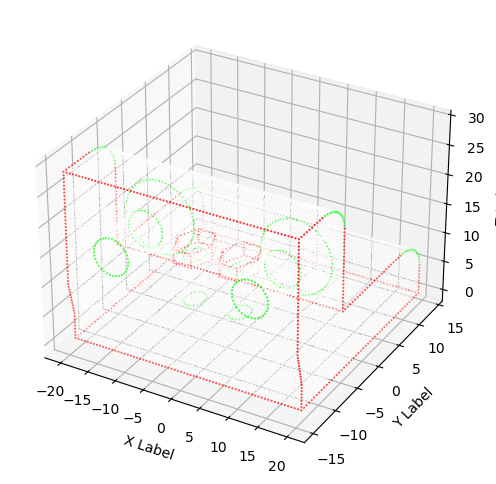

In [8]:
display_df(plydata)

# Traitement des données .ply

Pour utiliser le .ply dans notre modèle PyTorch (https://pytorch.org/), on passera par un Dataset modifié qui lors du chargement du .ply rajoutera les kppv comme information à l'aide de la librarie sklearn (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

In [9]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [10]:
def add_k_nearest_neighbors(df, k):
    coordinates = df[['x', 'y', 'z']].to_numpy()

    nn = NearestNeighbors(n_neighbors=k+1, algorithm='auto', n_jobs=-1).fit(coordinates)
    distances, indices = nn.kneighbors(coordinates)

    for i in range(1, k+1):
        df[f'k_nearest_x_{i}'] = coordinates[indices[:, i], 0]
        df[f'k_nearest_y_{i}'] = coordinates[indices[:, i], 1]
        df[f'k_nearest_z_{i}'] = coordinates[indices[:, i], 2]

# Définition du modèle

Pour rappel notre modèle prend en entrée un point et ses kppv et donne en sortie son type (si c'est un bord ou non).

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [12]:
k=10
model = keras.Sequential([
        layers.Dense(k, activation='relu'),
        layers.Dense(2, activation='softmax')
    ])

# Données du modèle

Pour l'entraînement on utilisera une pièce du dossier train et pour la validation on utilisera toutes les pièces du dossier validation. Et on utilisera une pièce autre que celle utilisée dans le train pour donner un exemple de résultat (pour l'affichage).

In [13]:
from tqdm import tqdm
from keras.utils import to_categorical

In [14]:
def load_files_to_dataframe(path, file_list, k):
    dataframes_list = []
    for file in tqdm(file_list):
        file_path = path+file+'.ply'
        df = read_ply_file(file_path)
        add_k_nearest_neighbors(df, k)
        dataframes_list.append(df)

    final_df = pd.concat(dataframes_list, ignore_index=True)
    
    return final_df

In [15]:
afficher_dataset = load_files_to_dataframe(train_path_folder, ["0008"], k)

train_file_list = ['0000', '0001', '0002', '0004', '0005', '0008', '0011', '0013', '0041', '0042', '0043', '0044', '0045', '0046', '0047', '0048', '0049', '0050', '0051', '0052', '0053', '0054', '0055', '0056', '0089', '0090', '0091', '0092', '0093', '0094', '0095', '0096', '0097', '0098', '0099', '0100', '0101', '0102', '0103', '0104', '0105', '0106', '0107', '0108', '0109', '0110', '0111', '0112', '0113', '0114', '0115', '0116', '0117', '0118', '0119', '0120', '0121', '0122', '0123', '0124', '0125', '0126', '0127', '0128', '0160', '0161', '0162', '0163', '0164', '0165', '0166', '0167', '0168', '0169', '0170', '0171', '0172', '0173', '0174', '0175', '0176', '0177', '0178', '0179', '0180', '0181', '0274', '0275', '0276', '0277', '0278', '0279', '0280', '0281', '0989', '0990', '0991', '0992', '0993', '0994', '0995', '0996', '0997', '0998']

train_dataset = load_files_to_dataframe(train_path_folder, train_file_list, k)
print("Fin chargement train")
validation_file_list = ['0141', '0228', '0508', '0658', '0755', '0782', '0820', '0917', '0142', '0229', '0509', '0659', '0756', '0783', '0821', '0918', '0143', '0230', '0510', '0660', '0757', '0784', '0822', '0919', '0144', '0231', '0511', '0661', '0758', '0785', '0823', '0920', '0145', '0232', '0512', '0662', '0759', '0786', '0824', '0921', '0146', '0233', '0513', '0663', '0760', '0787', '0825', '0922', '0147', '0234', '0514', '0664', '0761', '0788', '0826', '0923', '0148', '0235', '0515', '0665', '0762', '0789', '0827', '0924', '0149', '0236', '0516', '0666', '0763', '0790', '0828', '0925', '0150', '0237', '0654', '0667', '0764', '0791', '0829', '0225', '0238', '0655', '0668', '0765', '0817', '0830', '0226', '0239', '0656', '0753', '0766', '0818', '0831', '0227', '0507', '0657', '0754', '0767', '0819', '0916']

validation_dataset = load_files_to_dataframe(validation_path_folder, validation_file_list, k)
print("Fin chargement validation")

X_train = train_dataset.drop(columns=['target', 'red', 'green', 'blue'])
Y_train = train_dataset['target']
Y_train = to_categorical(Y_train, num_classes=2)

X_validation = validation_dataset.drop(columns=['target', 'red', 'green', 'blue'])
Y_validation = validation_dataset['target']
Y_validation = to_categorical(Y_validation, num_classes=2)

100%|██████████| 104/104 [00:45<00:00,  2.26it/s]


Fin chargement train


100%|██████████| 100/100 [00:38<00:00,  2.57it/s]


Fin chargement validation


# Apprentissage du modèle

On définit une fonction train (d'entraînement) avec arrêt prématuré et stockage des loss du dataset train et du dataset validation.

In [16]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy'
)

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, Y_train,
    validation_data=(X_validation, Y_validation),
    batch_size=128,
    epochs=100,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

Epoch 1/100
13855/42643 [========>.....................] - ETA: 1:27 - loss: 3.5164